# Bayesian Model Averaging Using the BIC

Initialize

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from basic_distributions import (fit_beta_binom, fit_binom, fit_nb, fit_poi,
                                 fit_uniform, fit_empirical)
from advanced_stats import (calc_BIC, bma_using_bic, cross_validate, 
                            bootstrap_uncertainty, model_func)

# Data
y = [2, 3, 7, 8, 4, 5, 10, 15, 8, 6, 3, 11]

# Calculate the mean of the data (MLE for lambda in Poisson distribution)
mean_y = np.mean(y)
variance_y = np.var(y)

# Define data range for the PMF plots
x = np.arange(0, int(max(y) * 1.5 + 1))


# Define the model names
model_names = ['Uniform', 'Poisson', 'Binomial', 'Negative Binomial', 'Beta-Binomial', 'Empirical']

model_names_cv = model_names[:-1] # don't use the empirical model for cross-validation

## Fitting a Uniform Distribution

In [12]:

log_likelihood_uniform, n_fitted_uniform, bic_uniform, uniform_pmf, _ = fit_uniform(y)

print(f"Fitted n (maximal value): {round(n_fitted_uniform,1)}")
print(f"BIC for the Uniform model: {int(bic_uniform)}")

Fitted n (maximal value): 15.0
BIC for the Uniform model: 67


## Fitting a Poisson Model

In [13]:
log_likelihood_poi, λ, bic_poi, _ = fit_poi(y)

print(f"Fitted λ (mean): {round(λ, 1)}")
print(f"BIC for the Poisson model: {int(bic_poi)}")

Fitted λ (mean): 6.8
BIC for the Poisson model: 69


## Fitting a Binomial Model

Fitted n (number of trials): 675
Fitted p (probability): 0.01
BIC for the Binomial model: 72


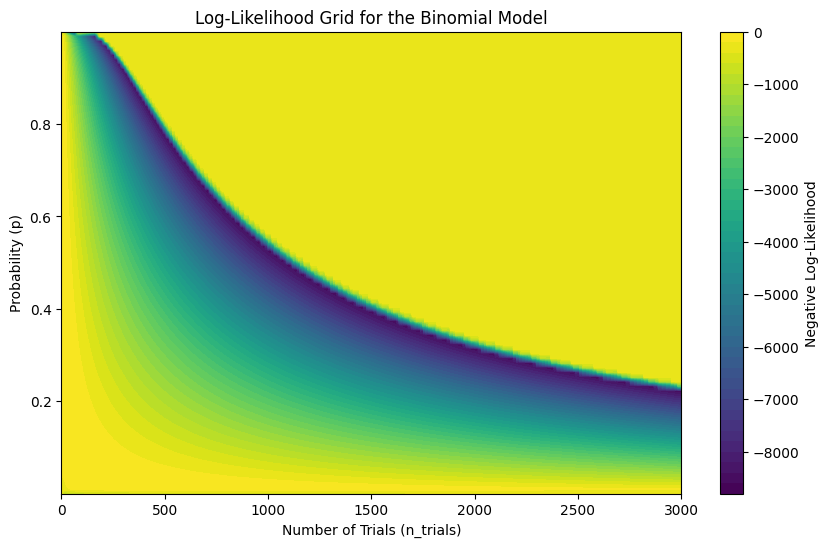

In [14]:
log_likelihood_binom, n_fitted_binom, p_fitted_binom, bic_binom, n_grid_binom, p_grid_binom, log_likelihood_grid_binom = fit_binom(y)

print(f"Fitted n (number of trials): {n_fitted_binom}")
print(f"Fitted p (probability): {round(p_fitted_binom, 3)}")
print("BIC for the Binomial model:", int(bic_binom))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(n_grid_binom, p_grid_binom, log_likelihood_grid_binom, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Trials (n_trials)')
plt.ylabel('Probability (p)')
plt.title('Log-Likelihood Grid for the Binomial Model')
plt.show()

## Fitting a Negative Binomial

Fitted r (number of claims until stop): 7.1
Fitted p (probability of a claim): 0.51
BIC for the Negative Binomial model: 68


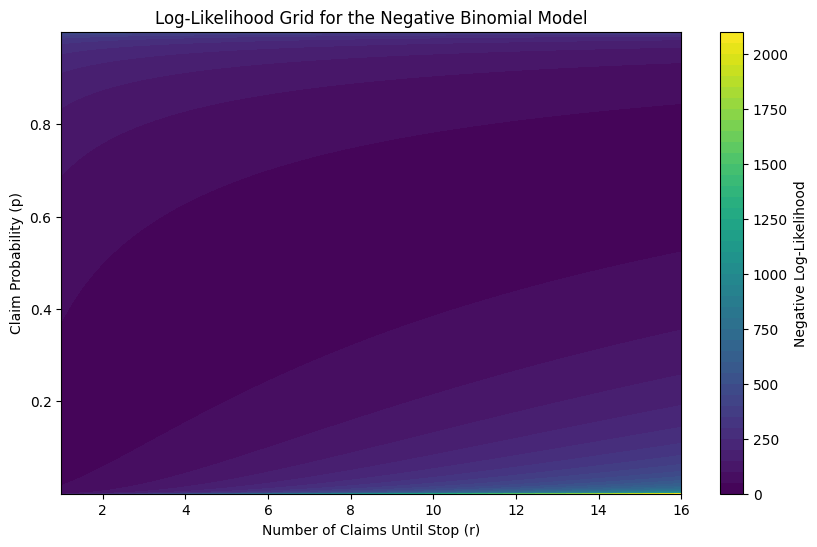

In [16]:
log_likelihood_nb, r_nb_fitted, p_nb_fitted, bic_nb, r_range_nb, p_range_nb, log_likelihood_matrix_nb = fit_nb(y, 4)

# Print the fitted parameters
print(f"Fitted r (number of claims until stop): {round(r_nb_fitted,1)}")
print(f"Fitted p (probability of a claim): {round(p_nb_fitted,2)}")
print("BIC for the Negative Binomial model:", int(bic_nb))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(r_range_nb, p_range_nb, log_likelihood_matrix_nb.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Claims Until Stop (r)')
plt.ylabel('Claim Probability (p)')
plt.title('Log-Likelihood Grid for the Negative Binomial Model')
plt.show()

## Fitting a Beta-Binomial

In [17]:
log_likelihood_bb, alpha_bb_fitted, beta_bb_fitted, bic_bb, beta_binomial_pmf, _ = fit_beta_binom(y)

print(f"Fitted α (expected number of successes): {round(alpha_bb_fitted,1)}")
print(f"Fitted β (expected number of failures): {round(beta_bb_fitted,1)}")
print("BIC for the Beta-Binomial model:", int(bic_bb))

Fitted α (expected number of successes): 1.9
Fitted β (expected number of failures): 2.2
BIC for the Beta-Binomial model: 69


## Fitting the Empirical Distribution

In [18]:
log_likelihood_emp, emp_probabilities, bic_emp, predictive_distribution, _ = fit_empirical(y)

print("BIC for the Empirical distribution:",  int(bic_emp))

BIC for the Empirical distribution: 83


## Model Averaging Using the Bayesian Information Criterion (BIC)

In [19]:
from scipy.stats import binom, nbinom, poisson

# Define the number of parameters for each model
param_counts = [1, 1, 2, 2, 2, len(y)]

# Define the BIC values for each model
bic_values = np.array([bic_uniform, bic_poi, bic_binom, bic_nb, bic_bb, bic_emp])

# Define the PMF values for each model
pmf_values = [uniform_pmf(x, n_fitted_uniform),
                poisson.pmf(x, mean_y),
                binom.pmf(x, n_fitted_binom, p_fitted_binom),
                nbinom.pmf(x, r_nb_fitted, p_nb_fitted),
                beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted),
                np.array([predictive_distribution(val) for val in x])]

# Perform Bayesian Model Averaging
weights, average_pmf, log_likelihood_bma, _, bic_averaged_model = bma_using_bic(model_names,
                                                                                param_counts,
                                                                                bic_values,
                                                                                pmf_values,
                                                                                y,
                                                                                y)


## Visualizing the Different Models

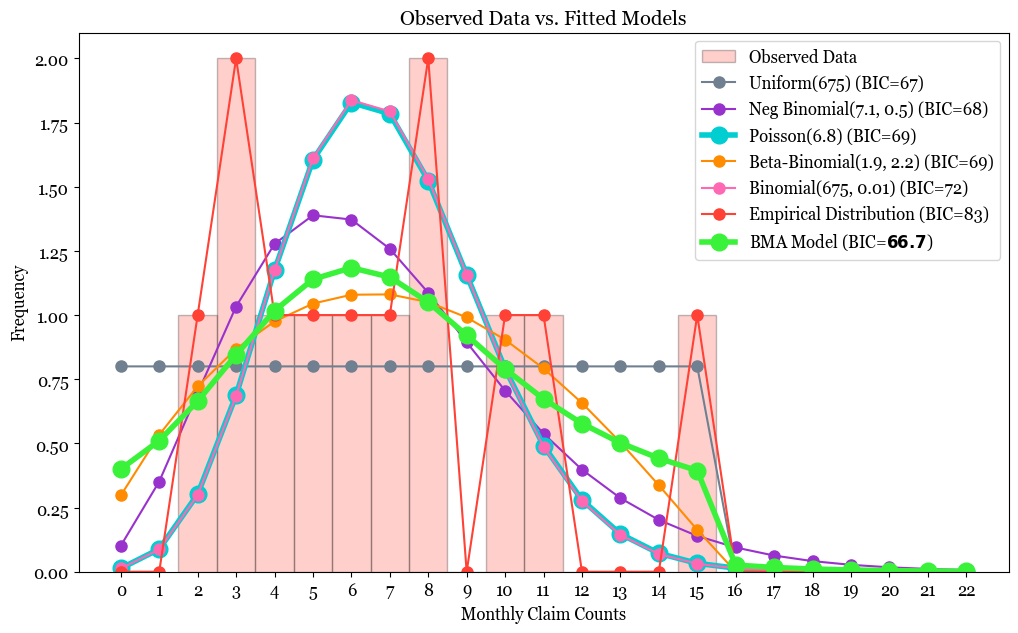

In [20]:
# Set the font properties
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 12

# Plot the observed data as a histogram
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

# Calculate the expected Uniform probabilities
uniform_pmf_values = uniform_pmf(x, n_fitted_uniform)
uniform_pmf_values = [x * len(y) for x in uniform_pmf_values]

# Overlay the fitted Uniform distribution
plt.plot(x, uniform_pmf_values, 'o-', label=f'Uniform({round(n_fitted_binom,1)}) (BIC={int(bic_uniform)})', color='#708090', markersize=8)

# Calculate the expected Negative Binomial probabilities
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted) * len(y)

# Overlay the fitted Negative Binomial distribution
plt.plot(x, nbinom_pmf, 'o-', label=f'Neg Binomial({round(r_nb_fitted,1)}, {round(p_nb_fitted,1)}) (BIC={int(bic_nb)})', color='#9932CC', markersize=8)

# Overlay the fitted Poisson distribution
poisson_pmf = poisson.pmf(x, mean_y) * len(y)
plt.plot(x, poisson_pmf, 'o-', label=f'Poisson({round(mean_y,1)}) (BIC={int(bic_poi)})', color='#00CED1', markersize=12, linewidth=4)

# Calculate the expected Beta-Binomial probabilities
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted) * len(y)

# Overlay the fitted Beta-Binomial distribution
plt.plot(x, beta_binom_pmf, 'o-', label=f'Beta-Binomial({round(alpha_bb_fitted,1)}, {round(beta_bb_fitted,1)}) (BIC={int(bic_bb)})', color='#FF8C00', markersize=8)

# Calculate the expected Binomial probabilities
binom_pmf = binom.pmf(x, n_fitted_binom, p_fitted_binom) * len(y)

# Overlay the fitted Binomial distribution
plt.plot(x, binom_pmf, 'o-', label=f'Binomial({n_fitted_binom}, {round(p_fitted_binom, 3)}) (BIC={int(bic_binom)})', color='#FF69B4', markersize=8)

# Calculate the empirical probabilities
empirical_pmf = np.array([emp_probabilities.get(val, 0) for val in x]) * len(y)

# Overlay the empirical distribution
plt.plot(x, empirical_pmf, 'o-', label=f'Empirical Distribution (BIC={int(bic_emp)})', color='#FF4136', markersize=8)

# Overlay the weighted average model
plt.plot(x, average_pmf * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{round(bic_averaged_model, 1)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(x)

plt.title('Observed Data vs. Fitted Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Cross-Validate to boost performance

In [21]:
# Perform cross-validation
weights_bma_cv, average_pmf_bma_cv, log_likelihood_bma_cv, param_num_bma_cv, bic_bma_cf, model_uncertainty = cross_validate(model_func, y, x, k=len(y))
print("Weighted performance across all folds:", round(bic_bma_cf, 1))

Weighted performance across all folds: 8.6


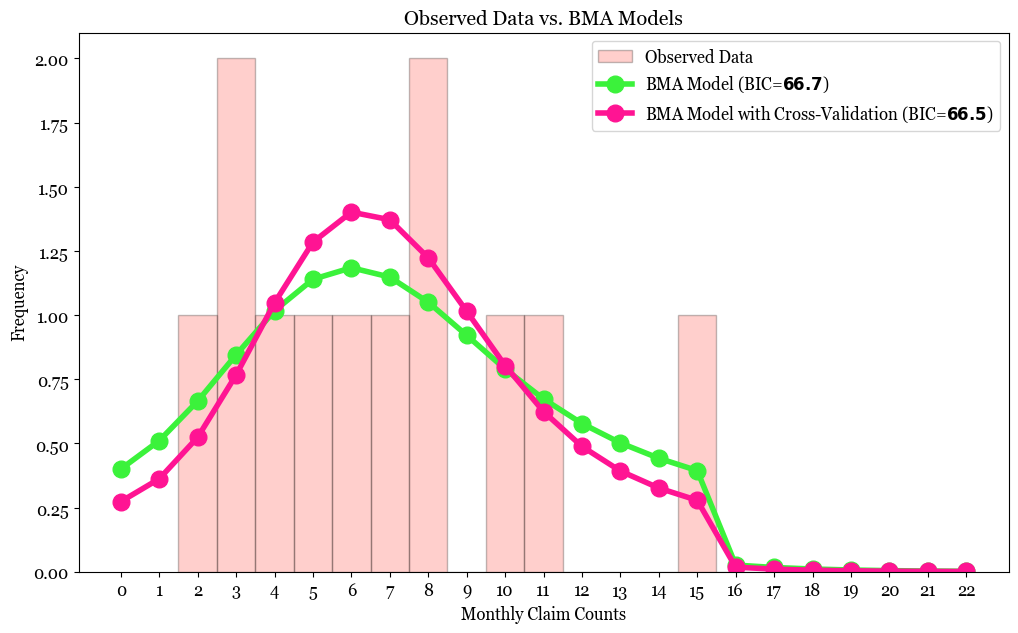

In [22]:
# Evaluate BIC for the BMA Cross-Validation Model
bic_bma_cv = round(calc_BIC(np.sum(np.log(average_pmf[y])), param_num_bma_cv, len(y)),2)

# Plot the average BMA Cross-Validation model
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

# Overlay the weighted average model
plt.plot(x, average_pmf * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{round(bic_averaged_model, 1)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Overlay the weighted average model
plt.plot(x, average_pmf_bma_cv * len(y), 'o-', label=f'BMA Model with Cross-Validation (BIC=$\\mathbf{{{round(bic_bma_cv,1)}}}$)', color='#FF1493', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(x)

plt.title('Observed Data vs. BMA Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()


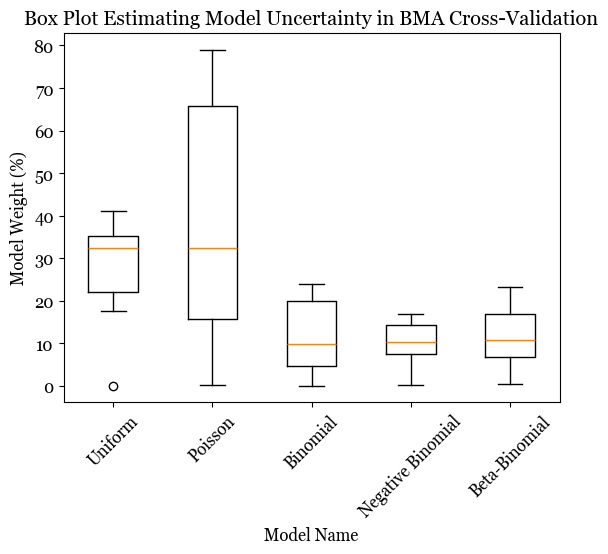

In [62]:
# print(weights_bma_cv) # BMA weight for each cross-validated fold
# average_pmf_bma_cv
# log_likelihood_bma_cv
# param_num_bma_cv
# bic_bma_cf
# print(model_uncertainty) # Weight of the individual component models in each BMA fold

# Get the weight of the individual component models in each fold, weighted by the BMA fit
# Multiply each column of the arrays by the respective elements in the array
result = [x * y for x, y in zip(weights_bma_cv, model_uncertainty)]

assert np.round(np.sum(result),4) == 1

result = np.array(result).reshape(len(weights_bma_cv), len(model_names_cv))

# Scale the weights by the number of folds to get the total weight of each model
result *= len(weights_bma_cv) * 100 # Multiply by 100 to get percentage

# Create the box plot
plt.boxplot(result)

# Label the axes
plt.xlabel('Model Name')
plt.ylabel('Model Weight (%)')
plt.title('Box Plot Estimating Model Uncertainty in BMA Cross-Validation')

# Set the x-axis labels
plt.xticks(ticks=np.arange(1, len(model_names_cv) + 1), labels=model_names_cv, rotation=45)

# Show the plot
plt.show()

## Evaluate parameter uncertainty

In [6]:
# Perform bootstrapping
bootstrap_results_with_params = bootstrap_uncertainty(model_func, y, x, n_bootstraps=1000, k_folds=len(y), max_workers=None, timeout=None)


In [ ]:
# Perform bootstrapping
# bootstrap_results = bootstrap_uncertainty(model_func, y, x, n_bootstraps=1000, k_folds=len(y), max_workers=None, timeout=None)


In [7]:
import pickle

# Save bootstrap results to a file
with open('bootstrap_results.pkl', 'wb') as f:
    pickle.dump(bootstrap_results, f)



In [50]:
# Aggregate the results to get uncertainty estimates
weights_bma_cv_all = np.array([result['weights_bma_cv'] for result in bootstrap_results])
average_pmf_bma_cv_all = np.array([result['average_pmf_bma_cv'] for result in bootstrap_results])
log_likelihood_bma_cv_all = np.array([result['log_likelihood_bma_cv'] for result in bootstrap_results])
param_num_bma_cv_all = np.array([result['param_num_bma_cv'] for result in bootstrap_results])
bic_bma_cv_all = np.array([result['bic_bma_cv'] for result in bootstrap_results])
model_uncertainty_all = np.array([result['model_uncertainty'] for result in bootstrap_results])

In [55]:
# Print the current shape
print("Current shape:", model_uncertainty_all.shape)

# Reshape the array to (12000, 5)
model_uncertainty_all_reshaped = model_uncertainty_all.reshape(-1, 5)

# Verify the new shape
print("New shape:", model_uncertainty_all_reshaped.shape)

Current shape: (1000, 12, 5)
New shape: (12000, 5)


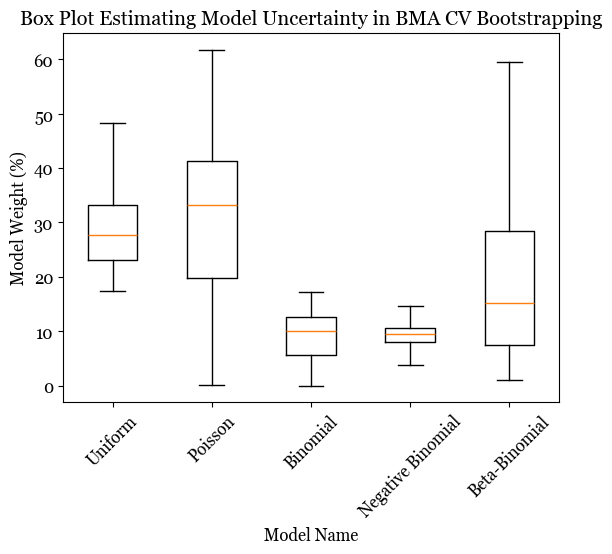

In [67]:
import seaborn as sns

# Calculate mean and standard deviation for the weights
mean_weights = np.mean(weights_bma_cv_all, axis=0)
std_weights = np.std(weights_bma_cv_all, axis=0)

# Calculate confidence intervals
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

confidence_intervals = np.percentile(weights_bma_cv_all, [lower_percentile, upper_percentile], axis=0)

# Plot the results
plt.boxplot(model_uncertainty_all_reshaped * 100, showfliers=False)

# Label the axes
plt.xlabel('Model Name')
plt.ylabel('Model Weight (%)')
plt.title('Box Plot Estimating Model Uncertainty in BMA CV Bootstrapping')

# Set the x-axis labels
plt.xticks(ticks=np.arange(1, len(model_names_cv) + 1), labels=model_names_cv, rotation=45)

plt.show()

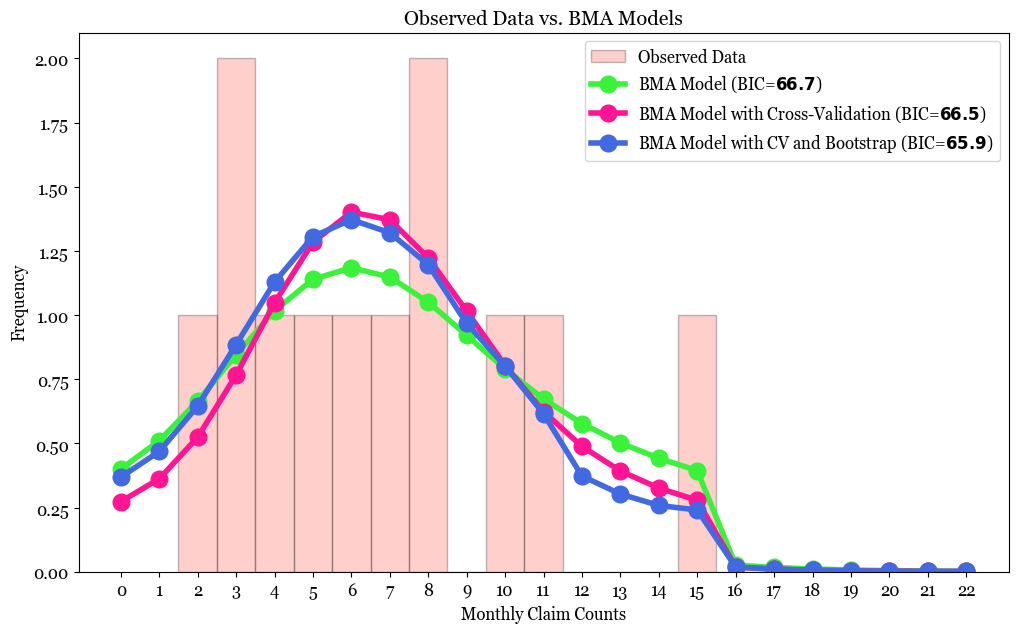

In [65]:
# Perform BMA of the bootstrapped models
model_names_bs = [str(f'Bootstrap Model {x}') for x in range(1,len(weights_bma_cv_all)+1)]

weights_bma_bs, average_pmf_bma_bs, log_likelihood_bma_bs, param_num_bma_bs, bic_bma_bs = bma_using_bic(model_names_bs,
                                                                                                        param_num_bma_cv_all,
                                                                                                        bic_bma_cv_all,
                                                                                                        average_pmf_bma_cv_all,
                                                                                                        y,
                                                                                                        y)

# Define data range
x = np.arange(0, int(max(y) * 1.5 + 1))

# Evaluate BIC for the BMA Cross-Validation Model
bic_bma_cv = round(calc_BIC(np.sum(np.log(average_pmf[y])), param_num_bma_cv, len(y)),2)

# Plot the average BMA Cross-Validation model
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

# Overlay the weighted average model
plt.plot(x, average_pmf * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{round(bic_averaged_model, 1)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Overlay the weighted average model
plt.plot(x, average_pmf_bma_cv * len(y), 'o-', label=f'BMA Model with Cross-Validation (BIC=$\\mathbf{{{round(bic_bma_cv,1)}}}$)', color='#FF1493', markersize=12, linewidth=4)

# Overlay the weighted average model
plt.plot(x, average_pmf_bma_bs * len(y), 'o-', label=f'BMA Model with CV and Bootstrap (BIC=$\\mathbf{{{round(bic_bma_bs,1)}}}$)', color='#4169E1', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(x)

plt.title('Observed Data vs. BMA Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()
